# Hello Fulcra: Connecting and Retrieving Your Data

> This notebook is an introduction to accessing your data using the Fulcra 
Data API. 

This version of the notebook contains the `FulcraAPI` class inside the 
notebook -- in the following cell.

In [9]:
import http.client, urllib.parse, json
from IPython.display import HTML, display
import datetime, time
import webbrowser
import pandas as pd
from typing import List, Tuple
import io

FULCRA_AUTH0_DOMAIN = "fulcra.us.auth0.com"
FULCRA_AUTH0_CLIENT_ID="48p3VbMnr5kMuJAUe9gJ9vjmdWLdnqZt"
FULCRA_AUTH0_AUDIENCE="https://api.fulcradynamics.com/"
FULCRA_AUTH0_SCOPE="openid profile name email offline_access"

class FulcraAPI:
    fulcra_cached_access_token = None
    fulcra_cached_access_token_expiration = None

    def get_auth_connection(self, domain: str) -> http.client.HTTPSConnection:
        """
        Returns an https connection to the given server.
        """
        return http.client.HTTPSConnection(domain)


    def request_device_code(self,
                            domain: str, 
                            client_id: str, 
                            scope: str, 
                            audience: str) -> Tuple[str, str, str]:
        """
        Requests a device code and complete verification URI from auth0.
        """
        conn = self.get_auth_connection(domain)
        body = urllib.parse.urlencode({
            "client_id": client_id,
            "audience": audience,
            "scope": scope
        })
        headers = {
            "Content-Type": "application/x-www-form-urlencoded",
        }
        conn.request("POST", "/oauth/device/code", body, headers)
        response = conn.getresponse()
        if response.status != 200:
            raise Exception(f"could not get device code: {response}")
        bdata = response.read()
        data = json.loads(bdata)
        return (data["device_code"], 
                data["verification_uri_complete"], 
                data["user_code"])


    def get_token(self, device_code: str) -> Tuple[str, datetime.datetime]:
        conn = self.get_auth_connection(FULCRA_AUTH0_DOMAIN)
        body = urllib.parse.urlencode({
            "client_id": FULCRA_AUTH0_CLIENT_ID,
            "grant_type": "urn:ietf:params:oauth:grant-type:device_code",
            "device_code": device_code
        })
        headers = {
            "Content-Type": "application/x-www-form-urlencoded",
        }
        conn.request("POST", "/oauth/token", body, headers)
        response = conn.getresponse()
        if response.status != 200:
            return (None, None)
        data = json.loads(response.read())
        if 'access_token' not in data:
            return (None, None)
        expires_in = datetime.datetime.now() + \
            datetime.timedelta(seconds=float(data['expires_in']))
        return (data['access_token'], expires_in)


    def authorize(self):
        """
        Request a device token, then prompt the user to authorize it.

        This uses the Device Authorization workflow, which requires the user
        to visit a link and confirm that the code shown on the screen matches.
        
        Raises an exception on failure.
        """
        if self.fulcra_cached_access_token is not None \
            and self.fulcra_cached_access_token_expiration is not None \
            and self.fulcra_cached_access_token_expiration > datetime.datetime.now():
            display(HTML("<p>Your access token is still valid.</p>"))
            return self.fulcra_cached_access_token
        device_code, uri, code = self.request_device_code(FULCRA_AUTH0_DOMAIN, 
                                                    FULCRA_AUTH0_CLIENT_ID, 
                                                    FULCRA_AUTH0_SCOPE, 
                                                    FULCRA_AUTH0_AUDIENCE)
        webbrowser.open_new_tab(uri)
        display(HTML(f'<a href="{uri}" target="_blank">' + \
            'Use your browser to log in to Fulcra.  If ' + \
            ' the tab does not open automatically, click here to ' + \
            'log in to Fulcra.</a>  The code displayed will ' + \
            f'be: <b>{code}</b><p>After you have authorized, ' + \
            'close the browser tab.</p>'))
        stop_at = datetime.datetime.now() + datetime.timedelta(seconds=120)
        while datetime.datetime.now() < stop_at:
            time.sleep(0.5)
            token, expiration_date = self.get_token(device_code)
            if token != None:
                display(HTML("Authorization succeeded."))
                self.fulcra_cached_access_token = token
                self.fulcra_cached_access_token_expiration = expiration_date
                return
        self.fulcra_cached_access_token = None
        self.fulcra_cached_access_token_expiration = None
        raise Exception("Authorization failed.  Re-run these cells.")

    def fulcra_api(self, access_token: str, url_path: str) -> bytes:
        """
        Make a call to the given url path (e.g. `/v0/data/time_series_grouped?...`)
        with the specified access token.

        Returns the raw response data (as bytes).  Raises an exception on failure.
        """
        conn = http.client.HTTPSConnection("api.fulcradynamics.com")
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        conn.request("GET", url_path, headers=headers)
        response = conn.getresponse()
        if response.status != 200:
            raise Exception(f"request failed: {response.read()}")
        return response.read()


    def time_series_grouped(
            self,
            start_time: str,
            end_time: str,
            metrics: List[str],
            sample_rate: float = 60,
    ):
        """Retrieve a time-series data frame containing the specified set of
        Fulcra metrics from start_time (inclusive) until end_time (exclusive).

        If specified, the sample_rate parameter defines the number of 
        seconds per sample.  This value can be smaller than 1.  The default 
        value is 60 (one sample per minute).

        When specified as strings, start_time and end_time must be in ISO8601
        format.

        Requires a valid access token.
        """
        qparams = urllib.parse.urlencode({
            "start_time": start_time,
            "end_time": end_time,
            "metrics": metrics,
            "output": "arrow",
            "samprate": sample_rate
        }, doseq=True)
        resp = self.fulcra_api(
            self.fulcra_cached_access_token,
            "/data/v0/time_series_grouped?" + qparams
        )
        return pd.read_feather(io.BytesIO(resp)).set_index("time")


To make calls to the Fulcra API, create an instance of the `FulcraAPI` class:

In [11]:
fulcra = FulcraAPI()

## Logging in to Fulcra

To make calls to the API, call `authorize()` first.  You authorize the `FulcraAPI`
instance using your browser.  The `authorize()` function will generate a link below
that you should click to log in to Fulcra.  (Depending on the notebook front-end 
you're using, this tab may open automatically.)

Once you've logged in, close the tab; you should see "Authorization succeeded" 
displayed in the notebook output.  

In [13]:
fulcra.authorize()

## Retrieving Time Series Data

Once your `FulcraAPI` instance is authorized, you can now use it 
to make API calls.

The `time_series_grouped` function returns a Pandas dataframe.

In [15]:
df = fulcra.time_series_grouped(
    start_time = "2023-07-01 04:00:00.000Z",
    end_time = "2023-07-10 04:00:00.000Z",
    metrics=["DistanceTraveledOnFoot", 
        "AppleWatchExerciseTime",
        "ActiveCaloriesBurned",
        "BasalCaloriesBurned"
    ]
)
df

,distance_on_foot,apple_watch_exercise_time,active_calories_burned,basal_calories_burned
time,,,,
2023-07-01 04:00:00+00:00,NaN,<NA>,0.124000,1.333887
2023-07-01 04:01:00+00:00,NaN,<NA>,0.187429,1.333887
2023-07-01 04:02:00+00:00,NaN,<NA>,0.191016,1.333887
2023-07-01 04:03:00+00:00,NaN,<NA>,0.243587,1.333887
2023-07-01 04:04:00+00:00,NaN,<NA>,0.290446,1.333887
...,...,...,...,...
2023-07-10 03:55:00+00:00,0.000000,<NA>,0.371190,1.375441
2023-07-10 03:56:00+00:00,0.000856,<NA>,0.280462,1.583422
2023-07-10 03:57:00+00:00,NaN,<NA>,0.358275,1.607226


<Axes: xlabel='time'>

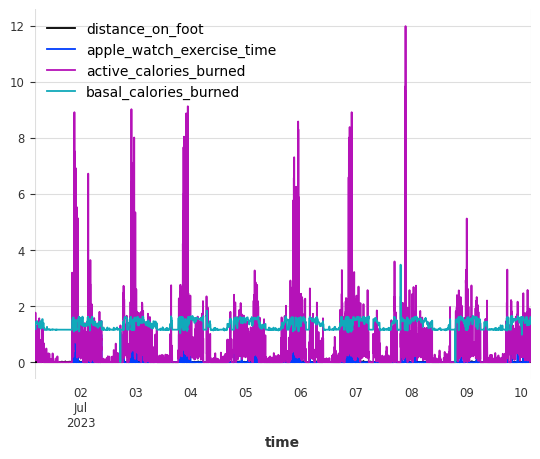

In [16]:
df.plot()